# Environment

In [79]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [80]:
# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MECP2')

# Load Data

In [81]:
DEA_NEU = pd.read_csv("DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("DEA_NSC.csv", header=0)

In [82]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,H2afy2,898.006083,-0.000002,0.096164,-0.000017,0.999986,0.999986
1,Lurap1l,248.853019,0.000021,0.175418,0.000119,0.999905,0.999970
2,Tcea1,1680.603269,0.000090,0.088197,0.001019,0.999187,0.999963
3,Igdcc4,872.289717,0.000126,0.100337,0.001255,0.998999,0.999963
4,Kdm6a,792.508606,-0.000035,0.108607,-0.000325,0.999741,0.999963


In [83]:
DEA_NEU.shape

(12945, 7)

In [84]:
DEA_NEU = DEA_NEU[DEA_NEU['padj'] < 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['padj'] < 0.05]

In [85]:
print(DEA_NEU.shape)
print(DEA_NSC.shape)

(2115, 7)
(8908, 7)


In [86]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
10830,Etohd2,52.179960,-0.875472,0.325480,-2.689789,0.007150,0.049950
10831,Prepl,6734.833093,-0.182629,0.067887,-2.690180,0.007141,0.049914
10832,Slk,2299.724144,-0.235697,0.087604,-2.690482,0.007135,0.049914
10833,Tomm34,630.507422,-0.309322,0.114977,-2.690304,0.007139,0.049914
10834,Selenon,323.325362,-0.378338,0.140572,-2.691420,0.007115,0.049798


In [87]:
mecp2_NEU = pd.read_csv("allgenes_NEU.csv", header=0)
mecp2_NSC = pd.read_csv("allgenes_NSC.csv", header=0)

In [88]:
print(mecp2_NEU.shape)
print(mecp2_NSC.shape)

(80, 6)
(467, 6)


In [89]:
mecp2_NEU.head()

,gene,baseMean,log2FoldChange,Direction,Endogenous_Promoter,Exogenous_Promoter
0,Abcg2,230.797511,0.825216,UP,False,True
1,AW551984,581.286456,0.749896,UP,False,True
2,Bend5,155.132445,0.577849,UP,False,True
3,Cgn,176.027310,0.683605,UP,False,True
4,Crhr2,85.668042,0.805206,UP,False,True


In [127]:
def volcano_plot(df1, df2, p_value_threshold=0.05, fc_threshold=1, labels=True, promoter_type='Exogenous_Promoter'):
    # Calculate -log10(pvalue) for df1
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])

    # Create a color mapping based on df2
    color_mapping = {}
    alpha_mapping = {}
    size_mapping = {}
    
    # Set default color/alpha for genes not in df2
    for gene in df1['gene']:
        color_mapping[gene] = 'lightgrey'
        alpha_mapping[gene] = 0.8
        size_mapping[gene] = 20  

    # Override for genes found in df2
    for gene in df2['gene'].values:
        if gene in df1['gene'].values:
            if df2[df2['gene'] == gene][promoter_type].iloc[0]:
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] > 0:
                    color_mapping[gene] = 'green'
                    alpha_mapping[gene] = 1
                    size_mapping[gene] = 30  
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] < 0:
                    color_mapping[gene] = 'red'
                    alpha_mapping[gene] = 1
                    size_mapping[gene] = 30  

    # Create color list in the same order as df1
    colors = [color_mapping[gene] for gene in df1['gene']]
    alphas = [alpha_mapping[gene] for gene in df1['gene']]
    sizes = [size_mapping[gene] for gene in df1['gene']]
    plt.figure(figsize=(10, 8))

    # Plot background points first (lightgrey)
    background_mask = [c == 'lightgrey' for c in colors]
    plt.scatter(df1.loc[background_mask, 'log2FoldChange'],
            df1.loc[background_mask, 'neg_log_pvalue'],
            c='lightgrey',
            alpha=0.3,
            s=10)

    # Plot colored points on top
    colored_mask = [c != 'lightgrey' for c in colors]
    plt.scatter(df1.loc[colored_mask, 'log2FoldChange'],
            df1.loc[colored_mask, 'neg_log_pvalue'],
            c=[c for c, m in zip(colors, colored_mask) if m],
            alpha=1,
            s=30)

    # Add labels and title
    plt.xlabel('log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.title('Volcano Plot of Differential Expression', fontsize=14)

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Create custom legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='green', label=f'{promoter_type} Enriched', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='lightgrey', label='Not in df2', markersize=7)]

    plt.legend(handles=legend_elements, loc='upper right')

    if labels:
        # Add gene labels for significant genes
        pvalue_threshold = -np.log10(p_value_threshold)
        fc_threshold = fc_threshold 

        for idx, row in df1.iterrows():
            if (abs(row['log2FoldChange']) > fc_threshold) and (row['neg_log_pvalue'] > pvalue_threshold):
                plt.annotate(row['gene'], 
                            (row['log2FoldChange'], row['neg_log_pvalue']),
                            xytext=(5, 5), 
                            textcoords='offset points',
                            fontsize=8)

    plt.tight_layout()

    plt.show()

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


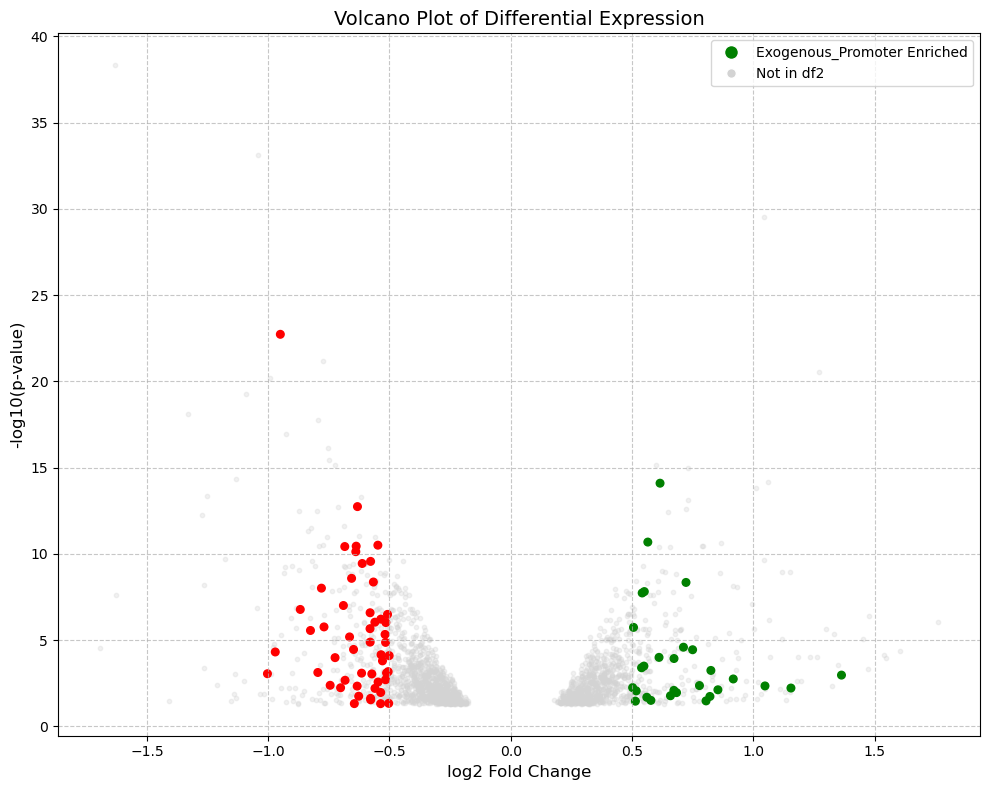

In [128]:
volcano_plot(DEA_NEU, mecp2_NEU, p_value_threshold=0.05, fc_threshold=1, labels=False, promoter_type='Exogenous_Promoter')

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


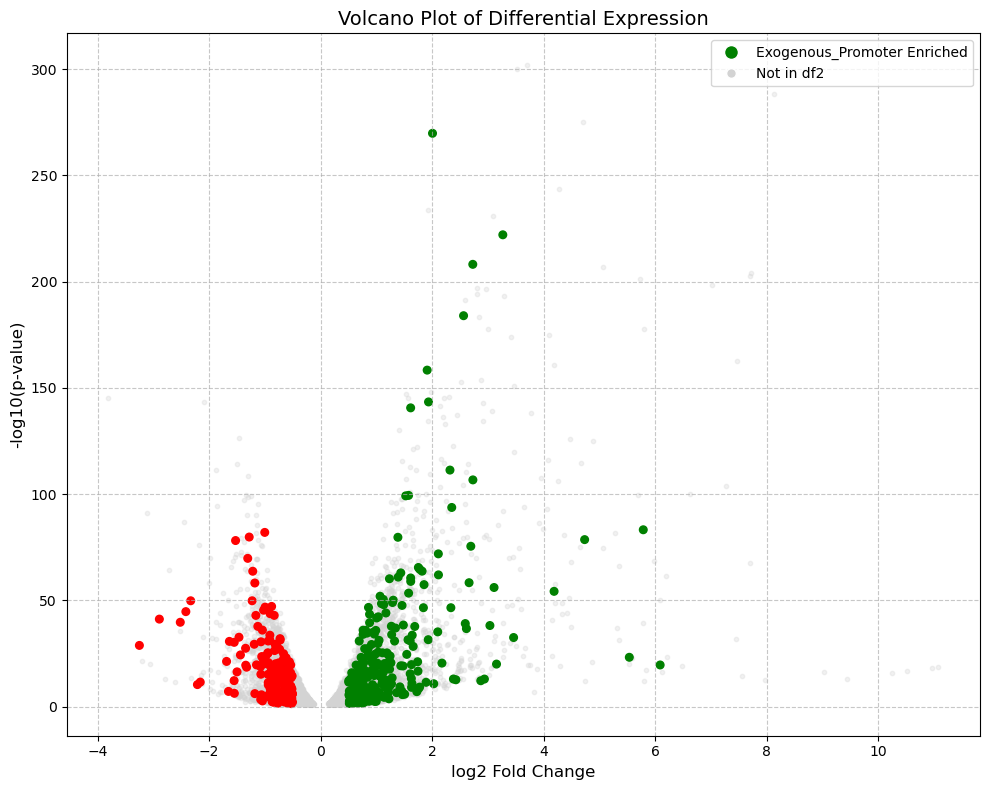

In [129]:
volcano_plot(DEA_NSC, mecp2_NSC, p_value_threshold=0.05, fc_threshold=4, labels=False, promoter_type='Exogenous_Promoter')

In [135]:
def volcano_plot_mod(df1, df2, p_value_threshold=0.05, fc_threshold=1, labels=True, promoter_type='Exogenous_Promoter'):
    # Calculate -log10(pvalue) for df1
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])

    # Create a color mapping based on df2
    color_mapping = {}
    alpha_mapping = {}
    size_mapping = {}
    
    # Set default color/alpha for genes not in df2
    for gene in df1['gene']:
        color_mapping[gene] = 'lightgrey'
        alpha_mapping[gene] = 0.8
        size_mapping[gene] = 10  

    # Override for genes found in df2
    for gene in df2['gene'].values:
        if gene in df1['gene'].values:
            if df2[df2['gene'] == gene][promoter_type].iloc[0]:
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] > 0:
                    color_mapping[gene] = 'green'
                    alpha_mapping[gene] = 1
                    size_mapping[gene] = 20  
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] < 0:
                    color_mapping[gene] = 'red'
                    alpha_mapping[gene] = 1
                    size_mapping[gene] = 20  

    # Create color list in the same order as df1
    colors = [color_mapping[gene] for gene in df1['gene']]
    alphas = [alpha_mapping[gene] for gene in df1['gene']]
    sizes = [size_mapping[gene] for gene in df1['gene']]

    # Create masks for background and colored points
    background_mask = [c == 'lightgrey' for c in colors]
    colored_mask = [c != 'lightgrey' for c in colors]

    # Split data into background and colored points
    background_data = {
        'x': df1.loc[background_mask, 'log2FoldChange'],
        'y': df1.loc[background_mask, 'neg_log_pvalue']
    }
    
    colored_data = {
        'x': df1.loc[colored_mask, 'log2FoldChange'],
        'y': df1.loc[colored_mask, 'neg_log_pvalue'],
        'colors': [c for c, m in zip(colors, colored_mask) if m]
    }

    return background_data, colored_data


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


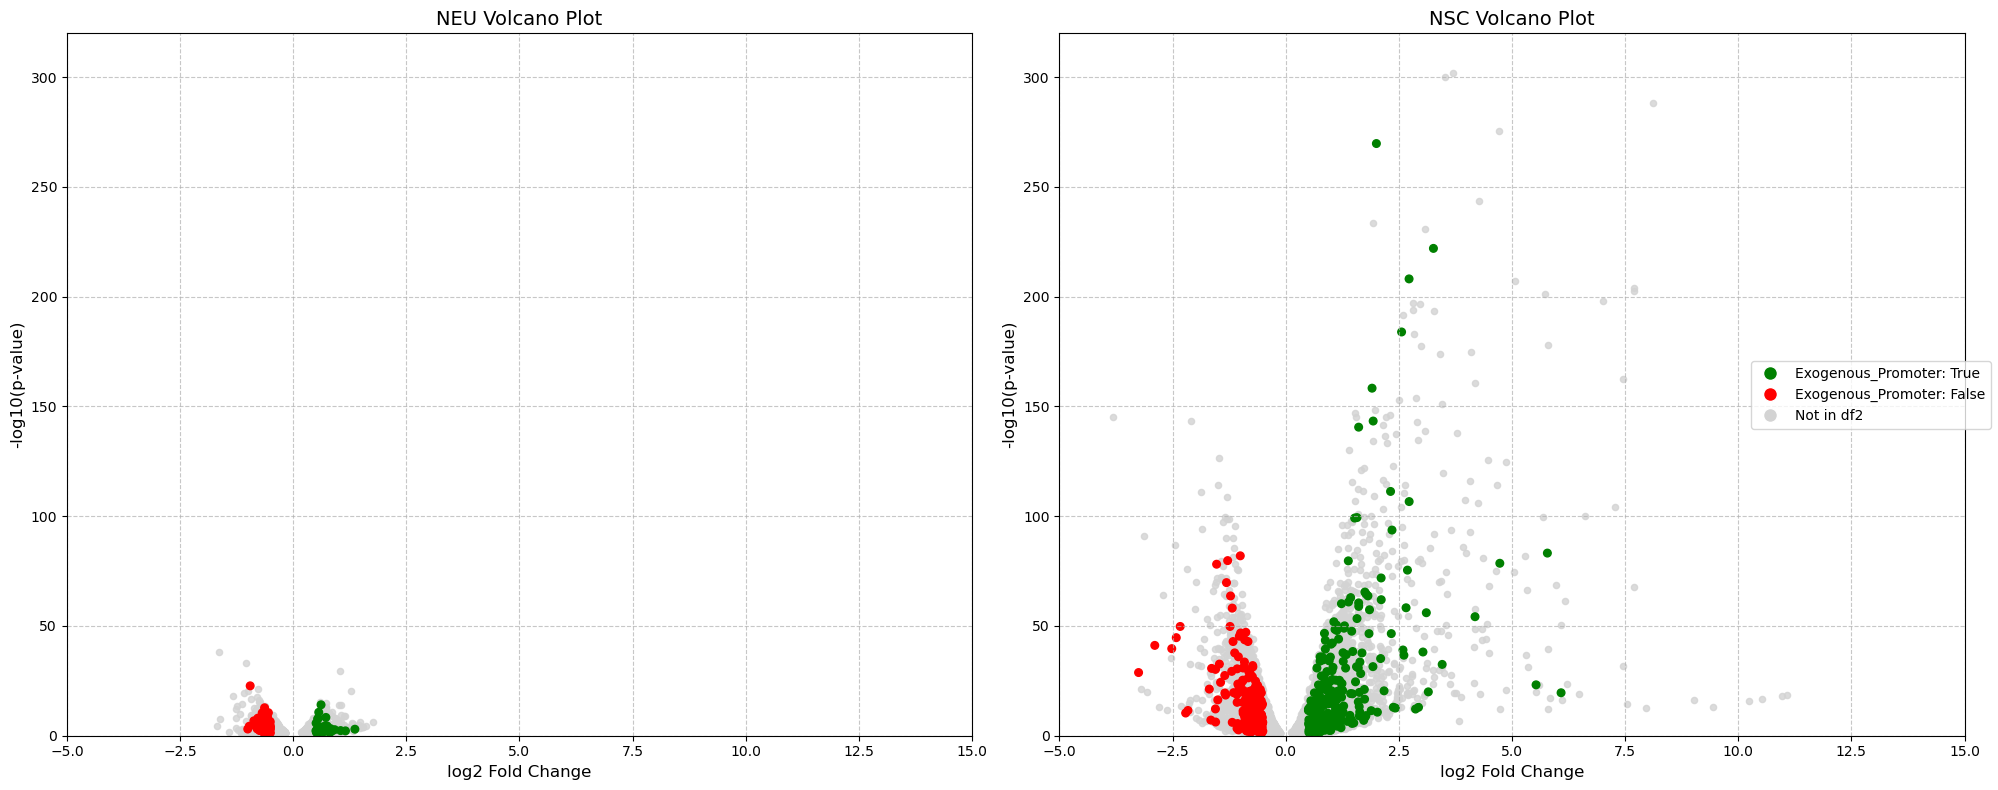

In [137]:
promoter_type='Exogenous_Promoter'

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Get data for both plots
background_data1, colored_data1 = volcano_plot_mod(DEA_NEU, mecp2_NEU, promoter_type=promoter_type)
background_data2, colored_data2 = volcano_plot_mod(DEA_NSC, mecp2_NSC, promoter_type=promoter_type)

x_min = -5
x_max = 15
y_min = 0
y_max = 320

# Plot first volcano plot
ax1.scatter(background_data1['x'], background_data1['y'], c='lightgrey', alpha=0.8, s=20)
ax1.scatter(colored_data1['x'], colored_data1['y'], c=colored_data1['colors'], alpha=1, s=30)
ax1.set_xlabel('log2 Fold Change', fontsize=12)
ax1.set_ylabel('-log10(p-value)', fontsize=12)
ax1.set_title('NEU Volcano Plot', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# # Add labels for first plot if needed
# if True:  # For NEU plot
#     pvalue_threshold = -np.log10(0.05)
#     fc_threshold = 2
#     for x, y, gene in zip(background_data1['x'].tolist() + colored_data1['x'].tolist(), 
#                          background_data1['y'].tolist() + colored_data1['y'].tolist(), 
#                          DEA_NEU['gene']):
#         if (abs(x) > fc_threshold) and (y > pvalue_threshold):
#             ax1.annotate(gene, (x, y), xytext=(5, 5), 
#                         textcoords='offset points', fontsize=8)

# Plot second volcano plot
ax2.scatter(background_data2['x'], background_data2['y'], c='lightgrey', alpha=0.8, s=20)
ax2.scatter(colored_data2['x'], colored_data2['y'], c=colored_data2['colors'], alpha=1, s=30)
ax2.set_xlabel('log2 Fold Change', fontsize=12)
ax2.set_ylabel('-log10(p-value)', fontsize=12)
ax2.set_title('NSC Volcano Plot', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Create custom legend (only need it once since it's the same for both)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='green', label=f'{promoter_type}: True', markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', label=f'{promoter_type}: False', markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='lightgrey', label='Not in df2', markersize=10)]

# Add legend to figure
fig.legend(handles=legend_elements, loc='center right')

plt.tight_layout()
plt.show()